In [1]:
import numpy as np
import xarray as xr

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

from preprocessingTools import *

In [17]:
test=dat_to_xarray("data/fullrun789/sph_pwr_layer_s.dat")

In [18]:
test

<xarray.Dataset>
Dimensions:            (t_step: 100, radial_id: 3)
Coordinates:
  * t_step             (t_step) int64 15780200 15780400 ... 15799800 15800000
  * radial_id          (radial_id) int64 310 330 355
    time               (t_step) float64 7.793 7.793 7.793 ... 7.795 7.795 7.795
Data variables: (12/20)
    K_ene_pol          (t_step, radial_id) float64 4.274e+03 ... 1.006e+03
    K_ene_tor          (t_step, radial_id) float64 7.74e+04 ... 1.754e+03
    K_ene              (t_step, radial_id) float64 8.168e+04 ... 2.76e+03
    temperature        (t_step, radial_id) float64 0.001164 ... 4.65e-07
    M_ene_pol          (t_step, radial_id) float64 0.1686 0.1215 ... 0.1026
    M_ene_tor          (t_step, radial_id) float64 0.3515 0.1032 ... 0.0009172
    ...                 ...
    inertia_pol        (t_step, radial_id) float64 9.216e+13 ... 4.483e+14
    inertia_tor        (t_step, radial_id) float64 6.884e+12 ... 1.442e+10
    inertia            (t_step, radial_id) float64 9.904e+13 ... 4.483e+14
    Lorentz_force_pol  (t_step, radial_id) float64 5.151e+13 ... 9.396e+12
    Lorentz_force_tor  (t_step, radial_id) float64 3.062e+12 ... 3.441e+13
    Lorentz_force      (t_step, radial_id) float64 5.457e+13 ... 4.381e+13

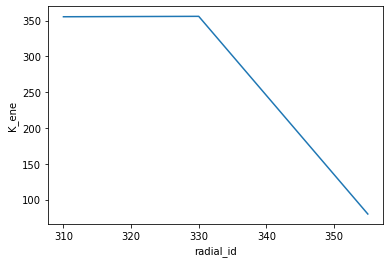

In [19]:
np.sqrt(2*test.K_ene.mean('t_step')).plot()

In [21]:
300*0.4/2270e3*1e3

0.05286343612334802

In [25]:
0.38/0.052

7.307692307692308

In [23]:
500*0.4/2000e3*1e3

0.1

# Conversion to netCDF & visualization

Transforming Calypso outputs to a xarray.Dataarray, then to saving to netCDF format (note the data is too big to upload on github)

In [14]:
%time forcings_m3 = dat_to_xarray("data/data808/picked_mode_808_m3_forcings.dat")
forcings_m3

CPU times: user 54.9 s, sys: 22.9 s, total: 1min 17s
Wall time: 1min 36s


<xarray.Dataset>
Dimensions:                (degree: 253, order: 1, radius_ID: 100, t_step: 800)
Coordinates:
  * t_step                 (t_step) int64 16160025 16160050 ... 16180000
  * radius_ID              (radius_ID) int64 261 262 263 264 ... 357 358 359 361
  * degree                 (degree) int64 3 4 5 6 7 8 ... 251 252 253 254 255
  * order                  (order) int64 3
    time                   (t_step) float64 7.831 7.831 7.831 ... 7.833 7.833
    radius                 (radius_ID) float64 1.36 1.363 1.366 ... 1.538 1.538
Data variables:
    temperature            (t_step, radius_ID, degree, order) float64 -0.0123...
    magnetic_field_pol     (t_step, radius_ID, degree, order) float64 -0.0032...
    magnetic_field_tor     (t_step, radius_ID, degree, order) float64 -0.103 ...
    magnetic_field_pol_dr  (t_step, radius_ID, degree, order) float64 0.09638...
    Lorentz_force_pol      (t_step, radius_ID, degree, order) float64 2.834e+...
    Lorentz_force_tor      (t_step, radius_ID, degree, order) float64 1.42e+0...
    Lorentz_force_pol_dr   (t_step, radius_ID, degree, order) float64 1.455e+...

In [15]:
#Save to netCDF format
forcings_m3.to_netcdf("data/data808/forcings_m3.nc")

xarray allows to easily differentiate the temperature field in time, giving a quick visualization of buoyancy fluctuations in the stratified layer

Text(0.5, 0, 'time (years)')

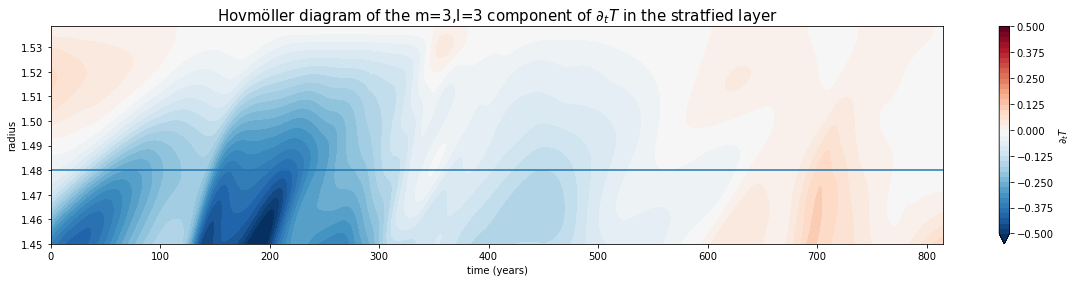

In [16]:
# Visualize a radius/time plot using xarray's plotting shortcuts

def ntsteps_to_years(n):
    L=2270e3
    pm=0.5
    eta=0.8
    return n*(L**2/eta/pm/86400/365.25 * 1e-7)

dt_temperature=(forcings_m3.temperature.differentiate('t_step')/(25e-7)).rename(r"$\partial_t T$")
dt_temperature_plot=dt_temperature.assign_coords(time = ntsteps_to_years(forcings_m3.t_step-forcings_m3.t_step[0])).swap_dims({'t_step':'time','radius_ID':'radius'})

fig,ax=plt.subplots(1,1,figsize=(20,4))
dt_temperature_plot.sel(degree=3,order=3).plot.contourf(ax=ax,x='time',levels=np.linspace(-.5,.5,41))#,cmap=plt.cm.RdBu_r)

ax.set_ylim(1.45,1.5385) 
ax.axhline(1.48) # Layer base 
ax.set_title(r'Hovmöller diagram of the m=3,l=3 component of $\partial_t T$ in the stratfied layer',fontsize=15)
ax.set_xlabel('time (years)')

We also convert the m=-3 part of the forcings

In [ ]:
%time forcings_mm3 = dat_to_xarray("data/data808/picked_mode_808_mm3.dat")

In [ ]:
# Also convert the m=-3 outputs to netcdf
forcings_mm3 = dat_to_xarray("data/data808/picked_mode_mm3.dat")
forcings_mm3.drop(['velocity_pol','velocity_tor','velocity_pol_dr','pressure','heat_source']).to_netcdf("data/data808/forcings_mm3.nc")

# Transformation to spherical coordinates

## Temperature

In [6]:
%%time
# Create a grid and convert from (time, radius, degree) space to (time, radius, cos(latitude)) space. 
# Each quantity (in this example, temperature) is Fourier transformed in phi.
ngrid=300
y = np.cos(np.linspace(0.,np.pi,ngrid+2)[1:-1][::-1]) #exclude the -1 and 1 bounds to avoid divisions by 0
temperature_y_m3  = interp_scalar(y, forcings_m3.temperature ,  3)
temperature_y_mm3 = interp_scalar(y, forcings_mm3.temperature, -3)
#Add the m=+3 and m=-3 components
temperature_y = temperature_y_m3+temperature_y_mm3

CPU times: user 3min 37s, sys: 2min 44s, total: 6min 21s
Wall time: 6min 46s


In [23]:
# save to netcdf
temperature_y.to_netcdf("data/data808/temperature_y_300_cos.nc")

Now we can visualize the buoyancy force on a spherical surface. We already have T as a function of t,r and y, so we simply need to differentiate in time, pick a time and radius, and multiply by $e^{im\phi}$ to get the $\phi$ dependence.

In [10]:
theta = np.arccos(y)
phi = np.linspace(0, 2*np.pi, ngrid)
phi_xr=xr.DataArray(phi,coords={'phi':phi},dims=['phi'])
#theta, phi = np.meshgrid(theta, phi)
phi, theta  = np.meshgrid(phi, theta)

# The Cartesian coordinates of the unit sphere
X = np.sin(theta) * np.cos(phi)
Y = np.sin(theta) * np.sin(phi)
Z = np.cos(theta)

In [8]:
dt_temperature_y=(temperature_y.differentiate('t_step')/(25e-7)).sel(t_step=0,radius_ID=1.48,method='nearest')
dt_temperature_yphi = np.real((dt_temperature_y.temperature_real+1j*dt_temperature_y.temperature_imag)*np.exp(1j*3*phi_xr))

Text(0.5, 0.92, 'm=3 component of $\\partial_t T$ at t=0 and r=1.48 (base of stratified layer)')

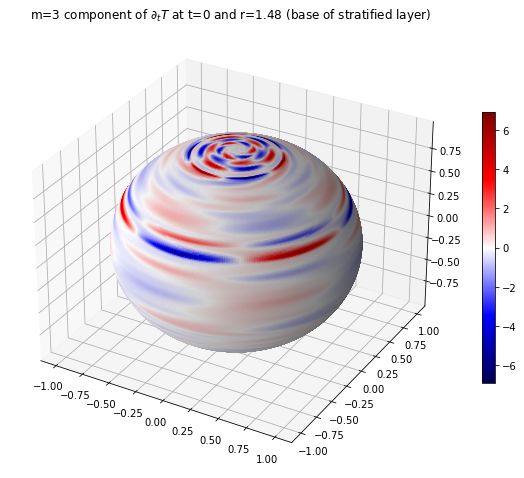

In [9]:
fig,ax = plt.subplots(1,1,figsize=(10.,10.), subplot_kw = {'projection':'3d'})
norm = clr.Normalize(vmin=dt_temperature_yphi.min(), vmax=dt_temperature_yphi.max())
surf=ax.plot_surface(X, Y, Z,  rstride=1, cstride=1, facecolors=plt.cm.seismic(norm(dt_temperature_yphi)))
m = plt.cm.ScalarMappable(cmap=plt.cm.seismic, norm=norm)
m.set_array([])
plt.colorbar(m,shrink=0.5)

ax.set_title("m=3 component of $\partial_t T$ at t=0 and r=1.48 (base of stratified layer)")


## Snapshot plot

In [25]:
temperature_y_phi0 = xr.open_dataset("data/data808/temperature_y_300_cos.nc").temperature_real
temperature_snapshot = temperature_y_phi0.isel(t_step=400)

In [30]:
y = np.array(temperature_snapshot.y)
r = np.array(temperature_snapshot.radius)
Y, R  = np.meshgrid(y, r)
X = R*np.sqrt(1-Y**2)
Y = R*Y


In [31]:
r.shape

(100,)

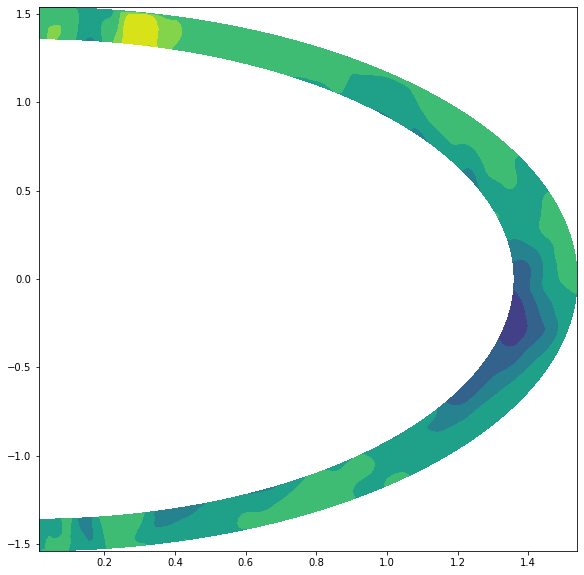

In [35]:
fig,ax = plt.subplots(1,1,figsize=(10.,10.))
ax.contourf(X,Y,temperature_snapshot)
ax.set_aspect(0.5)

<xarray.DataArray 'y' (y: 300)>
array([-0.999946, -0.999782, -0.99951 , ...,  0.99951 ,  0.999782,  0.999946])
Coordinates:
    t_step   int64 16170025
  * y        (y) float64 -0.9999 -0.9998 -0.9995 ... 0.9995 0.9998 0.9999
    time     float64 ...

## Lorentz force, magnetic field

In [13]:
forcings_m3=xr.open_dataset("data/data808/forcings_m3.nc")
forcings_mm3=xr.open_dataset("data/data808/forcings_mm3.nc")

In [ ]:
%%time
#takes 25 min
Lorentz_y_m3  = interp_vector(y, forcings_m3.drop(['temperature','magnetic_field_pol','magnetic_field_tor','magnetic_field_pol_dr']).squeeze(), 3)
Lorentz_y_mm3 = interp_vector(y, forcings_mm3.drop(['temperature','magnetic_field_pol','magnetic_field_tor','magnetic_field_pol_dr']).squeeze(), -3)
#Add the m=+3 and m=-3 components
Lorentz_y = Lorentz_y_m3+Lorentz_y_mm3
# save to netcdf
Lorentz_y.to_netcdf("data/data808/Lorentz_force_y_300_cos.nc")

In [15]:
%%time
#takes 25 min
B_y_m3  = interp_vector(y,  forcings_m3.drop(['temperature','Lorentz_force_pol','Lorentz_force_tor','Lorentz_force_pol_dr']).squeeze(), 3)
B_y_mm3 = interp_vector(y, forcings_mm3.drop(['temperature','Lorentz_force_pol','Lorentz_force_tor','Lorentz_force_pol_dr']).squeeze(), -3)
#Add the m=+3 and m=-3 components
B_y = B_y_m3+B_y_mm3
# save to netcdf
B_y.to_netcdf("data/data808/magnetic_field_y_300_cos.nc")

CPU times: user 11min 18s, sys: 8min 9s, total: 19min 28s
Wall time: 51min 11s
